# Technical Challenge - Traffic Signs Lucas Arnaldo Alves

Intuito desse notebook é ilustrar o pipeline de machine learning utilizando o conjunto de dados trafig sign.

O framework escolhido para modelagem da rede neural foi o TensorFlow.

Etapas:
- Data exploratory
- Data validation
- Data featuring (selection/construction)
- Model Selection
- Parameter Optimization
- Model validation
- Model Fine-tuning
- Deploy (only theoretical)
- Feedback of new validated data (only theoretical)

## Data exploratory

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [2]:
labels_csv_path = 'Labels.csv'
train_csv_path = 'Train.csv'
test_csv_path = 'Test.csv'
df_label = pd.read_csv(labels_csv_path)
df_train = pd.read_csv(train_csv_path)
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [3]:
df_train.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


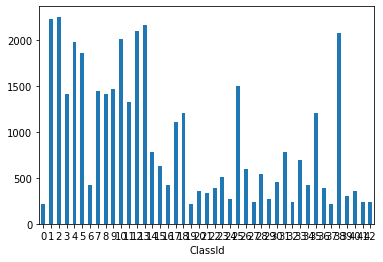

In [4]:
df_train.groupby('ClassId')['Path'].count().plot.bar(x='ClassId', y='Path', rot=0)

### Consideração em relação análise exploratória
Podemos observar que o tamanho das imagems não estão uniformizados.
Portando a escolha mais simples adotada foi realizar um subamostragem e utilizar todas em 25x25 em RGB.

Um problema associado ao conjuntos de dados encontrado foi o desbalanceamento em relação ao numero de imagem associado a cada classe. 
Como possivel solução podemos ponderar o treinamento/ajuste do modelo de maneira propocional ao numero de imagens associado a cada classe. Outra solução seria utilizar uma tecnica de aumento de dados para aumentar a diversidade e a representatividade das classes menos representadas.

## Data validation

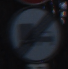

In [5]:
Image.open(df_train.iloc[-1,-1])

In [6]:
img_height = 25
img_width = 25
batch_size = 32
data_dir = 'Train'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    label_mode="categorical",
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    label_mode="categorical",
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 39209 files belonging to 43 classes.
Using 35289 files for training.
Found 39209 files belonging to 43 classes.
Using 3920 files for validation.


(32, 25, 25, 3)
(32, 43)


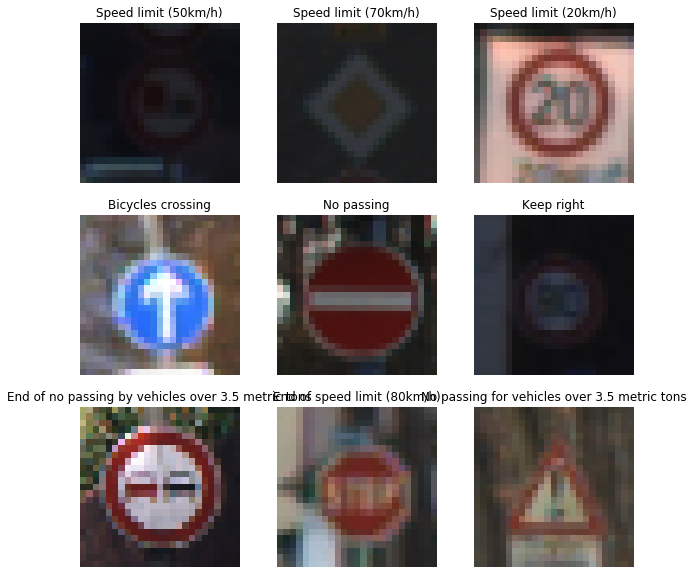

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(df_label.iloc[np.argmax(labels[i].numpy())].SignName)
        plt.axis("off")

### Consideração em relação validação dos dados
Como podemos notar que alem de uma baixa resolução existe diferentes condições de iluminação, borradas, com obstrução parcial em certas imagens. Uma sugestão para mitigar esses problemas seria a normalização da intensidade entre as imagens em uma etapa de pre-processamento.

## Data featuring

Iremos tratar esse problema utilizando os 3 canais disponiveis nas imagems RGB analisando cada pixel.

In [11]:
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=-1)
val_ds = val_ds.cache().prefetch(buffer_size=-1)

### Model Selection

Para abordar o problema de reconhecimento das placas a abordagem selecionada foi utilizar uma rede neural convolucional. Utilizando o framework Tensorflow para simplificar as etapas de descrição da arquitetura.

### Parameter Optimization

A otimização sera feita analizando a função de custo(perda de entropia cruzada), utilizando como metrica a acurácia.


In [13]:
num_classes = 43

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation = 'softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 25, 25, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)         

In [16]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
1103/1103 [==============================] - 4s 3ms/step - loss: 3.2136 - accuracy: 0.5866 - val_loss: 3.2153 - val_accuracy: 0.5837
Epoch 2/50
1103/1103 [==============================] - 4s 3ms/step - loss: 3.1850 - accuracy: 0.6154 - val_loss: 3.1822 - val_accuracy: 0.6176
Epoch 3/50
1103/1103 [==============================] - 4s 3ms/step - loss: 3.1769 - accuracy: 0.6237 - val_loss: 3.2123 - val_accuracy: 0.5878
Epoch 4/50
1103/1103 [==============================] - 4s 4ms/step - loss: 3.1805 - accuracy: 0.6197 - val_loss: 3.1860 - val_accuracy: 0.6140
Epoch 5/50
1103/1103 [==============================] - 4s 3ms/step - loss: 3.1622 - accuracy: 0.6382 - val_loss: 3.1543 - val_accuracy: 0.6452
Epoch 6/50
1103/1103 [==============================] - 4s 3ms/step - loss: 3.1443 - accuracy: 0.6562 - val_loss: 3.1530 - val_accuracy: 0.6469
Epoch 7/50
1103/1103 [==============================] - 4s 3ms/step - loss: 3.1476 - accuracy: 0.6528 - val_loss: 3.1564 - val_accuracy:

## Model validation


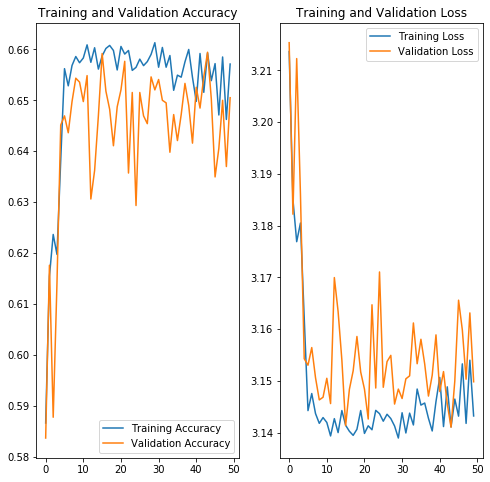

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
img = keras.preprocessing.image.load_img(
    df_train.iloc[-1,-1], target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(df_label.iloc[np.argmax(score)].SignName, 100 * np.max(score))
)

This image most likely belongs to Go straight or left with a 99.93 percent confidence.


In [25]:
test_csv_path = 'Test.csv'
df_test = pd.read_csv(test_csv_path,dtype='str')
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [29]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(dataframe=df_test,
                                            directory='',
                                            x_col=df_test.columns[-1],
                                            y_col=df_test.columns[-2],
                                            class_mode="categorical",
                                            shuffle=False,
                                            target_size=(img_height,img_width),
                                            batch_size=batch_size)

Found 12630 validated image filenames belonging to 43 classes.


In [31]:
test_acc_metric = tf.keras.metrics.Accuracy(name="accuracy", dtype=None)
for _ in range(len(test_generator)):
    x_batch_val, y_batch_val=next(test_generator)
    test_predictions=model(x_batch_val) 
    test_pred_norm = np.argmax(test_predictions,axis=1)
    test_acc_metric(y_batch_val, test_predictions)
    
test_acc = test_acc_metric.result()
test_acc_metric.reset_states()

print("Test accuracy: " + str(float(test_acc*100)) + "  Baseline Error: %.2f%%" % (100-float(test_acc*100)))

Test accuracy: 4.799941062927246  Baseline Error: 95.20%


### Consideração em relação ao modelo inicial
Podemos observar que o modelo não performou tão bem no conjunto de testes tendo apenas 5% de acurácia.
Como possibilidade para reajustar podemos introduzir uma normalização entre as batchs atraves de uma layer. Outra modificação que pode contribuir na generalização do modelo seria adicionar uma camada de Dropout para regularizar o ajuste da rede a diferentes configurações.

## Model Fine-tuning

In [20]:
model_2 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation = 'softmax')
])
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 25, 25, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 3)         12        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 25, 25, 16)        448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 64)         

In [21]:
epochs=50
history_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
1103/1103 [==============================] - 5s 4ms/step - loss: 3.6935 - accuracy: 0.1056 - val_loss: 3.6220 - val_accuracy: 0.1806
Epoch 2/50
1103/1103 [==============================] - 5s 5ms/step - loss: 3.5280 - accuracy: 0.2736 - val_loss: 3.4382 - val_accuracy: 0.3630
Epoch 3/50
1103/1103 [==============================] - 6s 6ms/step - loss: 3.4370 - accuracy: 0.3647 - val_loss: 3.4079 - val_accuracy: 0.3923
Epoch 4/50
1103/1103 [==============================] - 4s 4ms/step - loss: 3.3920 - accuracy: 0.4104 - val_loss: 3.3385 - val_accuracy: 0.4630
Epoch 5/50
1103/1103 [==============================] - 4s 4ms/step - loss: 3.3380 - accuracy: 0.4637 - val_loss: 3.3247 - val_accuracy: 0.4755
Epoch 6/50
1103/1103 [==============================] - 4s 4ms/step - loss: 3.3220 - accuracy: 0.4788 - val_loss: 3.3118 - val_accuracy: 0.4880
Epoch 7/50
1103/1103 [==============================] - 6s 5ms/step - loss: 3.3114 - accuracy: 0.4897 - val_loss: 3.3026 - val_accuracy:

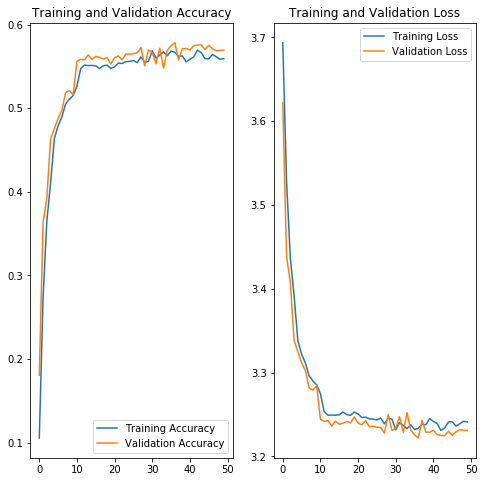

In [22]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
test_acc_metric = tf.keras.metrics.Accuracy(name="accuracy", dtype=None)
for _ in range(len(test_generator)):
    x_batch_val, y_batch_val=next(test_generator)
    test_predictions=model_2(x_batch_val) 
    test_acc_metric(y_batch_val, test_predictions)
    
test_acc = test_acc_metric.result()
test_acc_metric.reset_states()

print("Test accuracy: " + str(float(test_acc*100)) + "  Baseline Error: %.2f%%" % (100-float(test_acc*100)))

Test accuracy: 86.703857421875  Baseline Error: 13.30%


In [35]:
model_2.save('modelofinal.h5')

### Consideração em relação ao fine-tuning.
Tivemos uma expressiva melhora na performance do conjunto de teste com a solução proposta. alem de uma suavização da curva de treinamento.

Possiveis melhorias que não houve tempo para realização neste desafio técnico:

- Pre-processamento do conjunto de dados de maneira a uniformizar condições de iluminação.
- Trabalho de aumento de dados no processo de treinamento de maneira a melhor representar conjuntos com menor conjunto de imagens
- Tunning e teste de diferentes arquiteturas(Vgg,inception,dentre outros).

### Deploy (only theoretical)
Para o deploy poderia se montar uma API com auxilio da biblioteca Sanic que agrega funções assíncronas garantindo uma boa performance na inferencia de novos dados.

### Feedback of new validated data (only theoretical)
Com acumulo de novos dados validados. Seria possivel utilizar uma plataforma da tensorflow(TensorFlow Serving) para realizar o treinamento de distribuição de modelos em fase de produção. Dessa maneira a rede neural seria re-calibrada com novos dados de tempos em tempos. 